In [1]:
# This is the Kaggle Carvana Competition to segment Cars from the background.. Classical Deep Learning 
# Semantic Segmentation Implementation
# The below network basically tries to do a TensorFlow U-Net Implementation but without concatenating the features maps in the 
# downstream stage with the feature maps in the upstream stage. 
# Also the Model uses transpose Convolution instead of (upsampling + Conv).
# Image input of size 512x512

In [1]:

import tensorflow as tf

x = tf.placeholder(tf.float32,[None,512,512,3])
y = tf.placeholder(tf.float32,[None,512,512,1])

In [1]:
import tensorflow as tf

## Create  the different layers

# Define down sampling - 2 (Conv+ReLU) and 1 Maxpooling
# Maxpooling can be set to False when needed

x = tf.placeholder(tf.float32,[None,512,512,3])
y = tf.placeholder(tf.float32,[None,512,512,1])

def down_sample(x,w1,b1,w2,b2,pool=True):
    x = tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='SAME')
    x = tf.nn.bias_add(x,b1)
    x = tf.nn.relu(x)
    x = tf.nn.conv2d(x,w2,strides=[1,1,1,1],padding='SAME')
    x = tf.nn.bias_add(x,b2)
    x = tf.nn.relu(x)
    if pool:
        y = tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')  
        return y,x
    else:
        return x
    

def up_sample(x,w,b):
    output_shape  = x.get_shape().as_list()
    output_shape[0] = 4
    output_shape[1] *= 2
    output_shape[2] *= 2
    output_shape[1] = np.int(output_shape[1])
    output_shape[2] = np.int(output_shape[2])
    output_shape[3] = w.get_shape().as_list()[2]
    conv_tf = tf.nn.conv2d_transpose(value=x,filter=w,output_shape=output_shape,strides=[1,2,2,1],padding="SAME")
    conv_tf = tf.nn.bias_add(conv_tf,b)
    return tf.nn.relu(conv_tf)




## Define weights

weights = {
    'w11': tf.Variable(tf.random_normal([3,3,3,64],mean=0.0,stddev=0.02),name='w11'),
    'w12': tf.Variable(tf.random_normal([3,3,64,64],mean=0.0,stddev=0.02),name='w12'),
    'w21': tf.Variable(tf.random_normal([3,3,64,128],mean=0.0,stddev=0.02),name='w21'),
    'w22': tf.Variable(tf.random_normal([3,3,128,128],mean=0.0,stddev=0.02),name='w22'),
    'w31': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02),name='w31'),
    'w32': tf.Variable(tf.random_normal([3,3,256,256],mean=0.0,stddev=0.02),name='w32'),
    'w41': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02),name='w41'),
    'w42': tf.Variable(tf.random_normal([3,3,512,512],mean=0.0,stddev=0.02),name='w42'),
    'w51': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02),name='w51'),
    'w52': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02),name='w52'),
    'wu1': tf.Variable(tf.random_normal([3,3,1024,1024],mean=0.0,stddev=0.02),name='wu1'),
    'wu2': tf.Variable(tf.random_normal([3,3,512,1024],mean=0.0,stddev=0.02),name='wu2'),
    'wu3': tf.Variable(tf.random_normal([3,3,256,512],mean=0.0,stddev=0.02),name='wu3'),
    'wu4': tf.Variable(tf.random_normal([3,3,128,256],mean=0.0,stddev=0.02),name='wu4'),
    'wf': tf.Variable(tf.random_normal([1,1,128,1],mean=0.0,stddev=0.02),name='wf')
}
    
    

biases = {
    'b11': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02),name='b11'),
    'b12': tf.Variable(tf.random_normal([64],mean=0.0,stddev=0.02),name='b12'),
    'b21': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02),name='b21'),
    'b22': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02),name='b22'),
    'b31': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02),name='b31'),
    'b32': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02),name='b32'),
    'b41': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02),name='b41'),
    'b42': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02),name='b42'),
    'b51': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02),name='b51'),
    'b52': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02),name='b52'),
    'bu1': tf.Variable(tf.random_normal([1024],mean=0.0,stddev=0.02),name='bu1'),
    'bu2': tf.Variable(tf.random_normal([512],mean=0.0,stddev=0.02),name='bu2'),
    'bu3': tf.Variable(tf.random_normal([256],mean=0.0,stddev=0.02),name='bu3'),
    'bu4': tf.Variable(tf.random_normal([128],mean=0.0,stddev=0.02),name='bu4'),
    'bf': tf.Variable(tf.random_normal([1],mean=0.0,stddev=0.02),name='bf')
    
}

## Create the final model 

def unet_basic(x,weights,biases,dropout=1):
    
    ## Convolutional 1
    out1,res1 = down_sample(x,weights['w11'],biases['b11'],weights['w12'],biases['b12'],pool=True)
    out1,res1 = down_sample(out1,weights['w21'],biases['b21'],weights['w22'],biases['b22'],pool=True)
    out1,res1 = down_sample(out1,weights['w31'],biases['b31'],weights['w32'],biases['b32'],pool=True)
    out1,res1 = down_sample(out1,weights['w41'],biases['b41'],weights['w42'],biases['b42'],pool=True)
    out1      = down_sample(out1,weights['w51'],biases['b51'],weights['w52'],biases['b52'],pool=False)
    up1       = up_sample(out1,weights['wu1'],biases['bu1'])
    up1       = up_sample(up1,weights['wu2'],biases['bu2'])  
    up1       = up_sample(up1,weights['wu3'],biases['bu3'])  
    up1       = up_sample(up1,weights['wu4'],biases['bu4'])
    out       = tf.nn.conv2d(up1,weights['wf'],strides=[1,1,1,1],padding='SAME')
    out       = tf.nn.bias_add(out,biases['bf'])
    #out       = tf.nn.sigmoid(out)
    return out    
    

    
    
    
    
    

Using TensorFlow backend.


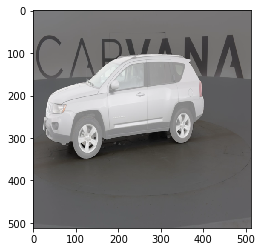

In [2]:
## Define image generators for both training dataset batches and validation batches so that images are read dynamically during 
## training time instead of pre-loading them in memory. This allows for efficient memory utilization.

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import os
from subprocess import check_output
import numpy as np
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from scipy.misc import imresize

# set the necessary directories
data_dir = "/home/santanu/Downloads/Carvana/train/"
mask_dir = "/home/santanu/Downloads/Carvana/train_masks/"
all_images = os.listdir(data_dir)
# pick which images we will use for testing and which for validation
train_images, validation_images = train_test_split(all_images, train_size=0.8, test_size=0.2)
# utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j])*3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img


# generator that we will use to read the data from the directory
def data_gen_small(data_dir, mask_dir, images, batch_size, dims):
        """
        data_dir: where the actual images are kept
        mask_dir: where the actual masks are kept
        images: the filenames of the images we want to generate batches from
        batch_size: self explanatory
        dims: the dimensions in which we want to rescale our images
        """
        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                original_img = load_img(data_dir + images[i])
                resized_img = imresize(original_img, dims+[3])
                array_img = img_to_array(resized_img)/255
                imgs.append(array_img)
                
                # masks
                original_mask = load_img(mask_dir + images[i].split(".")[0] + '_mask.gif')
                resized_mask = imresize(original_mask, dims+[3])
                array_mask = img_to_array(resized_mask)/255
                labels.append(array_mask[:, :, 0])
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

# example use
train_gen = data_gen_small(data_dir, mask_dir, train_images,4, [512, 512])
validation_gen = data_gen_small(data_dir, mask_dir, validation_images,4, [512, 512])
img, msk = next(train_gen)

plt.imshow(img[0])
plt.imshow(grey2rgb(msk[0]), alpha=0.5)



In [6]:
#Invoke TensorFlow graph
display_step=10
learning_rate=0.0001

keep_prob = tf.placeholder(tf.float32)
logits = unet_basic(x,weights,biases)
prob = tf.nn.sigmoid(logits,name='prob')
flat_logits = tf.reshape(tensor=logits, shape=(-1, 1))
flat_labels = tf.reshape(tensor=y,shape=(-1, 1))
cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)
cost = tf.reduce_mean(cross_entropies)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model 

## initializing all variables

init = tf.global_variables_initializer()

## Launch the execution Graph

with tf.Session() as sess:
    sess.run(init)
    for batch in xrange(4000):
        batch_x,batch_y= next(train_gen)
        sess.run(optimizer, feed_dict={x:batch_x,y:batch_y})
        loss = sess.run([cost],feed_dict={x:batch_x,y:batch_y})
        ## Validation loss and store the result for display at the end
        val_x,val_y = next(validation_gen)
        loss_val = sess.run([cost],feed_dict={x:val_x,y:val_y})
        out_x = sess.run(prob,feed_dict={x:val_x})
        print('batch:',batch,'train loss:',loss,'validation loss:',loss_val)
    saver = tf.train.Saver() 
    saver.save(sess, 'carvana_model_12')
        
        
          


('batch:', 0, 'train loss:', [0.68778437], 'validation loss:', [0.68854851])
('batch:', 1, 'train loss:', [0.68766904], 'validation loss:', [0.68788129])
('batch:', 2, 'train loss:', [0.68647963], 'validation loss:', [0.68698061])
('batch:', 3, 'train loss:', [0.68625361], 'validation loss:', [0.68634397])
('batch:', 4, 'train loss:', [0.68525863], 'validation loss:', [0.68546087])
('batch:', 5, 'train loss:', [0.68242413], 'validation loss:', [0.68256152])
('batch:', 6, 'train loss:', [0.67922878], 'validation loss:', [0.68019038])
('batch:', 7, 'train loss:', [0.6718244], 'validation loss:', [0.67031074])
('batch:', 8, 'train loss:', [0.66168082], 'validation loss:', [0.66443068])
('batch:', 9, 'train loss:', [0.64916986], 'validation loss:', [0.64750516])
('batch:', 10, 'train loss:', [0.60262185], 'validation loss:', [0.62064177])
('batch:', 11, 'train loss:', [0.58599246], 'validation loss:', [0.58441556])
('batch:', 12, 'train loss:', [0.5537895], 'validation loss:', [0.55098999]

In [2]:
#####################################################################
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

#import ams

input_size = 512
batch_size = 4
orig_width = 1918
orig_height = 1280
threshold=0.5

df_test = pd.read_csv('/home/santanu/Downloads/Carvana/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

rles = []

####################################################################


display_step=10
learning_rate=0.0001
import tensorflow as tf
saver = tf.train.Saver()
keep_prob = tf.placeholder(tf.float32)
logits = unet_basic(x,weights,biases)
prob = tf.nn.sigmoid(logits)
flat_logits = tf.reshape(tensor=logits, shape=(-1, 1))
flat_labels = tf.reshape(tensor=y,shape=(-1, 1))
cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)
cost = tf.reduce_mean(cross_entropies)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

####################################################################


with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    saver.restore(sess,'/home/santanu/carvana_model_4000')
    
    ########################################################################
    print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
    for start in tqdm(range(0, len(ids_test), batch_size)):
        x_batch = []
        end = min(start + batch_size, len(ids_test))
        ids_test_batch = ids_test[start:end]
        for id in ids_test_batch.values:
            img = cv2.imread('/home/santanu/Downloads/Carvana/test/{}.jpg'.format(id))
            img = cv2.resize(img, (input_size, input_size))
            x_batch.append(img)
        x_batch = np.array(x_batch, np.float32) / 255
        preds = sess.run([prob],feed_dict={x:x_batch})
        #print 'sucess one'
        preds = np.squeeze(preds, axis=3)
        for pred in preds:
            prob1 = cv2.resize(pred, (orig_width, orig_height))
            mask = prob1 > threshold
            rle = run_length_encode(mask)
            rles.append(rle)

    



  0%|          | 0/25016 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 4...


100%|██████████| 25016/25016 [2:56:16<00:00,  2.36it/s]  


In [3]:
print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('/home/santanu/Downloads/Carvana/submission_tf.csv.gz', index=False, compression='gzip')

Generating submission file...


In [19]:
## Generating the submission file for Kaggle
## Dice co-effecient of greater than 99%
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2

#import ams

input_size = 512
batch_size = 4
orig_width = 1918
orig_height = 1280
threshold=0.5

df_test = pd.read_csv('/home/santanu/Downloads/Carvana/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle

rles = []

####################################################################


display_step=10
learning_rate=0.0001
import tensorflow as tf
#saver = tf.train.Saver()
#keep_prob = tf.placeholder(tf.float32)
#logits = unet_basic(x,weights,biases)
#prob = tf.nn.sigmoid(logits)
#flat_logits = tf.reshape(tensor=logits, shape=(-1, 1))
#flat_labels = tf.reshape(tensor=y,shape=(-1, 1))
#cross_entropies = tf.nn.sigmoid_cross_entropy_with_logits(logits=flat_logits,
#                                                         labels=flat_labels)
#cost = tf.reduce_mean(cross_entropies)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


####################################################################


with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    new_saver = tf.train.import_meta_graph('/home/santanu/carvana_model_10.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
    graph = tf.get_default_graph()
    prob = graph.get_tensor_by_name("prob:0")
    batch_x,batch_y= next(train_gen)
    pred_out = sess.run(prob,feed_dict={x:batch_x})
    #print sess.graph.get_operations()
    

In [2]:
## Plotting segmented output image from validation dataset and its corresponding ground  truth
## Results have improved with higher image resolution


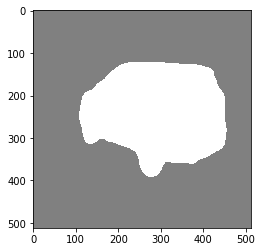

In [7]:
#Segmented Image from validation dataset
img = (out_x[0] > 0.5)*1.0
plt.imshow(grey2rgb(img),alpha=0.5)

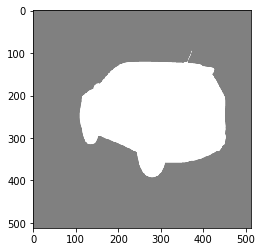

In [8]:
#Ground truth of validation dataset
ground = val_y[0]
plt.imshow(grey2rgb(val_y[0]), alpha=0.5)

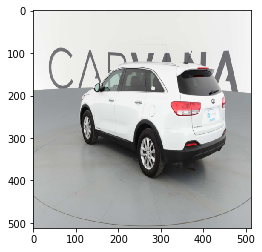

In [9]:
# actual validation dataset
plt.imshow(val_x[0],cmap='gray')

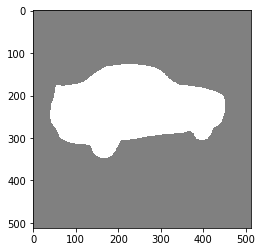

In [10]:
#Segmented Image from validation dataset
img = (out_x[1] > 0.5)*1.0
plt.imshow(grey2rgb(img),alpha=0.5)

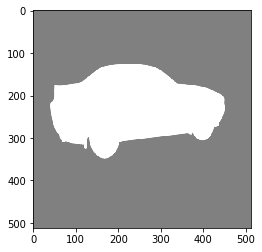

In [12]:
#Ground truth of validation dataset
ground = val_y[1]
plt.imshow(grey2rgb(val_y[1]), alpha=0.5)

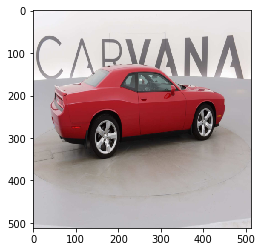

In [13]:
# actual validation dataset
plt.imshow(val_x[1],cmap='gray')

In [20]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

#import ams

input_size = 512
batch_size = 4
orig_width = 1918
orig_height = 1280
threshold=0.5

df_test = pd.read_csv('/home/santanu/Downloads/Carvana/sample_submission.csv')
ids_test = df_test['img'].map(lambda s: s.split('.')[0])

names = []
for id in ids_test:
    names.append('{}.jpg'.format(id))


# https://www.kaggle.com/stainsby/fast-tested-rle
def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


rles = []

#odel.load_weights(filepath='weights/best_weights.hdf5')

print('Predicting on {} samples with batch_size = {}...'.format(len(ids_test), batch_size))
for start in tqdm(range(0, len(ids_test), batch_size)):
    x_batch = []
    end = min(start + batch_size, len(ids_test))
    ids_test_batch = ids_test[start:end]
    for id in ids_test_batch.values:
        img = cv2.imread('/home/santanu/Downloads/Carvana/test/{}.jpg'.format(id))
        img = cv2.resize(img, (input_size, input_size))
        x_batch.append(img)
    x_batch = np.array(x_batch, np.float32) / 255
    with tf.Session() as sess:
        new_saver = tf.train.import_meta_graph('carvana_model_4000.meta')
        new_saver.restore(sess, tf.train.latest_checkpoint('./'))
        preds = sess.run(prob,feed_dict={x:x_batch})
    preds = np.squeeze(preds, axis=3)
    for pred in preds:
        prob = cv2.resize(pred, (orig_width, orig_height))
        mask = prob > threshold
        rle = run_length_encode(mask)
        rles.append(rle)

print("Generating submission file...")
df = pd.DataFrame({'img': names, 'rle_mask': rles})
df.to_csv('/home/santanu/Downloads/Carvana/submission_tf.csv.gz', index=False, compression='gzip')

  0%|          | 0/25016 [00:00<?, ?it/s]

Predicting on 100064 samples with batch_size = 4...


TypeError: Fetch argument array([[  4.49639338e-04,   4.49639338e-04,   3.98592907e-04, ...,
          2.87128816e-04,   3.31006799e-04,   3.31006799e-04],
       [  4.06032079e-04,   4.06032079e-04,   3.59868980e-04, ...,
          2.58458516e-04,   2.97956227e-04,   2.97956227e-04],
       [  2.31603102e-04,   2.31603102e-04,   2.04973301e-04, ...,
          1.43777375e-04,   1.65753998e-04,   1.65753998e-04],
       ..., 
       [  2.66164071e-13,   2.66164071e-13,   2.21618906e-13, ...,
          1.79456766e-26,   2.15345515e-26,   2.15345515e-26],
       [  4.79091918e-13,   4.79091918e-13,   3.98911237e-13, ...,
          3.22731224e-26,   3.87273050e-26,   3.87273050e-26],
       [  5.32327979e-13,   5.32327979e-13,   4.43237677e-13, ...,
          3.58552596e-26,   4.30258204e-26,   4.30258204e-26]], dtype=float32) has invalid type <type 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

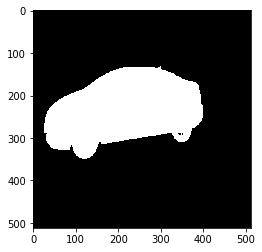

In [99]:
ground = np.reshape(ground,(512,512))
ground = np.uint8(ground)
ground 
plt.imshow(ground,cmap='gray')

[INFO] 29 unique segments found


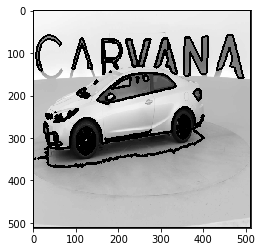

In [113]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed

## Load the coins image
#im = cv2.imread("val_img.jpg")
## Convert the image to gray scale
imgray = cv2.cvtColor(val_img*255,cv2.COLOR_BGR2GRAY)
imgray = np.uint8(imgray)
plt.imshow(imgray,cmap='gray')
# Threshold the image to convert it to Binary image based on Otsu's method
thresh = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
## Detect the contours and display them
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
y = cv2.drawContours(imgray, contours, -1, (0,255,0), 3)
## If we see the contour plots in the display of "y" 
## we see that the coins have a common contour and hence it is not possible to separate them
plt.imshow(y,cmap='gray')
## Hence we will proceed with the Watershed algorithm so that each of the coin form its own
## cluster and hence its possible to have separate contours for each coin.
## Relabel the thresholded image to be consisting of only 0 and 1 
## as the input image to distance_transform_edt should be in this format.
thresh[thresh == 255] = 5
thresh[thresh == 0] = 1
thresh[thresh == 5] = 0
## The distance_transform_edt and the peak_local_max functions helps building the markers by detecting 
## points near the centre points of the coins. One can skip these steps and create a marker
## manually by setting one pixel within each coin with a random number represneting its cluster
D = ndimage.distance_transform_edt(thresh)
D = np.reshape(ground,(512,512))
localMax = peak_local_max(D, indices=False, min_distance=10,labels=thresh)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
# Provide the EDT distance matrix and the markers to the watershed algorithm to detect the clusters
# labels for each pixel. For each coin, the pixels corresponding to it will be filled with the cluster number 
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
#Create the contours for each label(each coin and append to the plot)
for k in np.unique(labels):
    if k != 0 :
        labels_new = labels.copy()
        labels_new[labels == k] = 255
        labels_new[labels != k] = 0
        labels_new = np.array(labels_new,dtype='uint8')
        im2, contours, hierarchy = cv2.findContours(labels_new,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        z = cv2.drawContours(imgray,contours, -1, (0,255,0), 3)
        plt.imshow(z,cmap='gray')

In [112]:
np.shape(D)

(512, 512)

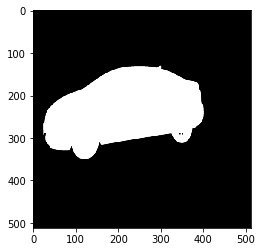

In [114]:
plt.imshow(D,cmap='gray')

In [48]:
a,thresh = cv2.threshold(imgray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

error: /io/opencv/modules/imgproc/src/thresh.cpp:1356: error: (-215) src.type() == CV_8UC1 in function threshold


In [45]:
ret2,th2 = cv2.threshold(imgray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

error: /io/opencv/modules/imgproc/src/thresh.cpp:1356: error: (-215) src.type() == CV_8UC1 in function threshold


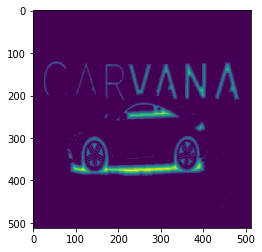

In [60]:
plt.imshow(D)

In [25]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('carvana_model_4000.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    preds = sess.run(prob,feed_dict={x:val_x})

TypeError: Fetch argument array([[  4.49639338e-04,   4.49639338e-04,   3.98592907e-04, ...,
          2.87128816e-04,   3.31006799e-04,   3.31006799e-04],
       [  4.06032079e-04,   4.06032079e-04,   3.59868980e-04, ...,
          2.58458516e-04,   2.97956227e-04,   2.97956227e-04],
       [  2.31603102e-04,   2.31603102e-04,   2.04973301e-04, ...,
          1.43777375e-04,   1.65753998e-04,   1.65753998e-04],
       ..., 
       [  2.66164071e-13,   2.66164071e-13,   2.21618906e-13, ...,
          1.79456766e-26,   2.15345515e-26,   2.15345515e-26],
       [  4.79091918e-13,   4.79091918e-13,   3.98911237e-13, ...,
          3.22731224e-26,   3.87273050e-26,   3.87273050e-26],
       [  5.32327979e-13,   5.32327979e-13,   4.43237677e-13, ...,
          3.58552596e-26,   4.30258204e-26,   4.30258204e-26]], dtype=float32) has invalid type <type 'numpy.ndarray'>, must be a string or Tensor. (Can not convert a ndarray into a Tensor or Operation.)

In [33]:
np.floor(val_img*255)

array([[[ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        ..., 
        [ 249.,  249.,  249.],
        [ 249.,  249.,  249.],
        [ 249.,  249.,  249.]],

       [[ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        ..., 
        [ 249.,  249.,  249.],
        [ 249.,  249.,  249.],
        [ 249.,  249.,  249.]],

       [[ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        [ 254.,  254.,  254.],
        ..., 
        [ 249.,  249.,  249.],
        [ 249.,  249.,  249.],
        [ 249.,  249.,  249.]],

       ..., 
       [[ 221.,  221.,  221.],
        [ 221.,  221.,  221.],
        [ 221.,  221.,  221.],
        ..., 
        [ 218.,  222.,  221.],
        [ 218.,  222.,  221.],
        [ 218.,  222.,  221.]],

       [[ 221.,  221.,  221.],
        [ 221.,  221.,  221.],
        [ 221.,  221.,  221.],
        ..., 
        [ 218.,  222.,  221.],
        [ 218.,  222.,  221.],
        [ 

In [40]:
np.int32(np.array([1., 2.]))


array([1, 2], dtype=int32)

In [53]:
imgray

array([[ -2,  -2,  -2, ...,  -7,  -7,  -7],
       [ -2,  -2,  -2, ...,  -7,  -7,  -7],
       [ -2,  -2,  -2, ...,  -7,  -7,  -7],
       ..., 
       [-35, -35, -35, ..., -35, -35, -35],
       [-35, -35, -35, ..., -35, -35, -35],
       [-35, -35, -35, ..., -35, -35, -35]], dtype=int8)